# Out-of-distribution Detection

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pwd
# %cd /content/drive/MyDrive/강의/AI_Expert_강의/Lab1:OOD-detection
%cd /content/drive/MyDrive/ai_expert/29_OOD_detection
# G:\내 드라이브\ai_expert\29_OOD_detection
!pwd

/content
/content/drive/MyDrive/ai_expert/29_OOD_detection
/content/drive/MyDrive/ai_expert/29_OOD_detection


In [3]:
import os
import time
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
import torchvision.transforms as trn
import torchvision.datasets as dset
from models.wrn import WideResNet
from sklearn.metrics import roc_curve, roc_auc_score

import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

In [4]:
pixel_mean = [125.3, 123.0, 113.9]
pixel_std = [63.0, 62.1, 66.7]
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

### Load Data

*   In-distribution data: CIFAR
*   Out-of-distribution data: SVHN

In [5]:
def load_dataset(dataset_name, bs_size=100, is_train=False, download=True):
    mean = [x / 255 for x in pixel_mean]
    std = [x / 255 for x in pixel_std]
    transforms = {"train": trn.Compose([trn.RandomHorizontalFlip(), trn.RandomCrop(32, padding=4),
                               trn.ToTensor(), trn.Normalize(mean, std)]),
                   "test": trn.Compose([trn.ToTensor(), trn.Normalize(mean, std)])}
    t_type = "train" if is_train else "test"
    if dataset_name == 'cifar10':
        data = dset.CIFAR10('./data/cifarpy', train=is_train, transform=transforms[t_type], download=download)
        num_classes = 10
    elif dataset_name == 'cifar100':
        data = dset.CIFAR100('./data/cifarpy', train=is_train, transform=transforms[t_type], download=download)
        num_classes = 100
    elif dataset_name == 'svhn':
        data = dset.SVHN(root='./data/svhn', split=t_type,
                             transform=transforms[t_type], download=download)
        num_classes = 10
    loader = torch.utils.data.DataLoader(data, batch_size=bs_size, shuffle=False, pin_memory=True)

    return loader, num_classes

In [6]:
in_test_loader, in_num_classes = load_dataset('cifar10', bs_size=128, download=True)
ood_test_loader, ood_num_classes = load_dataset('svhn', bs_size=128, download=True)

Files already downloaded and verified
Using downloaded and verified file: ./data/svhn/test_32x32.mat


### Load Model



*   WideResNet
*   Use the pretrained model with CIFAR10 dataset



In [7]:
def create_net(num_classes, layers=40, widen_factor=2, droprate=0.3, ckpt_path=None):
    net = WideResNet(layers, num_classes, widen_factor, dropRate=droprate)

    if ckpt_path is not None:
      if os.path.isfile(ckpt_path):
          net.load_state_dict(torch.load(ckpt_path))
          print('Model is successfully loaded!')
      else:
        print('Model checkpoint can not be loaded!')

    return net

In [8]:
net = create_net(in_num_classes, ckpt_path='./ckpt/wrn_pretrained_cifar10_epoch_99.pt')
net = net.to(device)
net.eval()

Model is successfully loaded!


WideResNet(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (block1): NetworkBlock(
    (layer): Sequential(
      (0): BasicBlock(
        (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)
        (conv1): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace=True)
        (conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (convShortcut): Conv2d(16, 32, kernel_size=(1, 1), stride=(1, 1), bias=False)
      )
      (1): BasicBlock(
        (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)
        (conv1): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(32, 

## Evaluation Metrics

#### FPR

In [9]:
def fpr_and_fdr_at_recall(y_true, y_score, recall_level=0.95, pos_label=None):
    classes = np.unique(y_true)
    if (pos_label is None and
            not (np.array_equal(classes, [0, 1]) or
                     np.array_equal(classes, [-1, 1]) or
                     np.array_equal(classes, [0]) or
                     np.array_equal(classes, [-1]) or
                     np.array_equal(classes, [1]))):
        raise ValueError("Data is not binary and pos_label is not specified")
    elif pos_label is None:
        pos_label = 1.

    # make y_true a boolean vector
    y_true = (y_true == pos_label)

    # sort scores and corresponding truth values
    desc_score_indices = np.argsort(y_score, kind="mergesort")[::-1]
    y_score = y_score[desc_score_indices]
    y_true = y_true[desc_score_indices]

    # y_score typically has many tied values.
    # Here we extract the indices associated with the distinct values.
    # We also concatenate a value for the end of the curve.
    distinct_value_indices = np.where(np.diff(y_score))[0]
    threshold_idxs = np.r_[distinct_value_indices, y_true.size - 1]

    # accumulate the true positives with decreasing threshold
    tps = np.cumsum(y_true)[threshold_idxs]
    fps = 1 + threshold_idxs - tps      # add one because of zero-based indexing

    thresholds = y_score[threshold_idxs]

    recall = tps / tps[-1]

    last_ind = tps.searchsorted(tps[-1])
    sl = slice(last_ind, None, -1)      # [last_ind::-1]
    recall, fps, tps, thresholds = np.r_[recall[sl], 1], np.r_[fps[sl], 0], np.r_[tps[sl], 0], thresholds[sl]

    cutoff = np.argmin(np.abs(recall - recall_level))

    return fps[cutoff] / (np.sum(np.logical_not(y_true)))   # , fps[cutoff]/(fps[cutoff] + tps[cutoff])

## Test

In [10]:
def test(net, in_loader, ood_loader, method="baseline", temperature=10, noise_magn=0.0014):
  net.eval()
  if method == "odin":
    inference = inference_odin
    argv = {'criterion': nn.CrossEntropyLoss(), 'noise_magn': noise_magn, 'temperature': temperature}
  elif method == "ebo":
    inference = inference_ebo
    argv = {'temperature': temperature}
  else:
    inference = inference_baseline
    argv = {}

  print("Processing in-distribution images")
  in_scores, in_accuracy = inference(net, in_loader, **argv)
  plot_scores(in_scores.cpu().numpy(), title="in-distribution", method=method)

  print("Processing out-of-distribution images")
  ood_scores, ood_accuracy = inference(net, ood_loader, **argv)
  plot_scores(ood_scores.cpu().numpy(), title="out-of-distribution", method=method)

  # detect ood samples
  total_scores = torch.cat([in_scores, ood_scores]).cpu().numpy()
  labels = torch.cat([torch.ones(len(in_test_loader.dataset)), torch.zeros(len(ood_test_loader.dataset))]).numpy()

  # evaluate ood detection performance
  # AUROC
  auroc = roc_auc_score(labels, total_scores)
  # FPR
  fpr95 = fpr_and_fdr_at_recall(labels, total_scores, 0.95)

  print("AUROC: {:.4f},\tFPR95: {:.4f}\n".format(auroc, fpr95))

  return total_scores, labels

In [11]:
def plot_scores(scores, title="", method="baseline"):
  if method == "ebo":
    _range = (scores.min(), scores.max())
  else:
    _range = (0., 1.)
  counts, bins = np.histogram(scores, bins=100, range=_range)
  plt.hist(bins[:-1], bins, weights=counts)
  plt.title(title)
  plt.show()

## Baseline

In [12]:
def inference_baseline(net, testloader):
    net.eval()
    total_num = len(testloader.dataset)
    scores = torch.Tensor([]).to(device)
    correct_predicts = 0
    t0 = time.time()
    for j, (images, gt_labels) in enumerate(testloader):
      outputs = net(images.to(device))
      probs, predicts = nn.Softmax(dim=1)(outputs).max(dim=1)

      scores = torch.cat([scores, probs.detach()])
      correct_predicts += (predicts == gt_labels.to(device)).sum()

      if j % 10 == 0:
        print("{:4}/{:4} batches processed, {:.1f} seconds used.".format(j+1, len(testloader), time.time() - t0))
        t0 = time.time()

    accuracy = correct_predicts / total_num
    print("Accuracy: {:.2f}%".format(accuracy * 100))

    return scores, accuracy

Processing in-distribution images
   1/  79 batches processed, 7.3 seconds used.
  11/  79 batches processed, 0.6 seconds used.
  21/  79 batches processed, 0.5 seconds used.
  31/  79 batches processed, 0.5 seconds used.
  41/  79 batches processed, 0.5 seconds used.
  51/  79 batches processed, 0.5 seconds used.
  61/  79 batches processed, 0.5 seconds used.
  71/  79 batches processed, 0.5 seconds used.
Accuracy: 94.84%


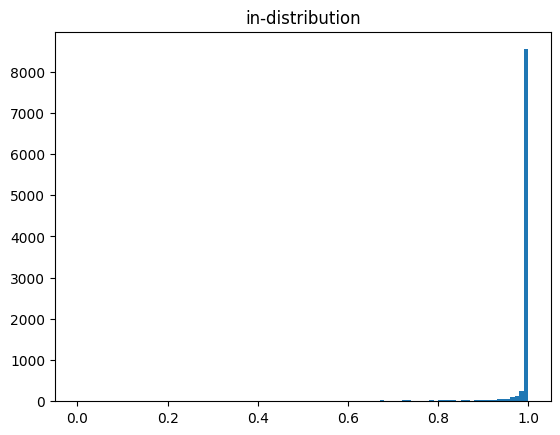

Processing out-of-distribution images
   1/ 204 batches processed, 0.1 seconds used.
  11/ 204 batches processed, 0.7 seconds used.
  21/ 204 batches processed, 0.7 seconds used.
  31/ 204 batches processed, 0.7 seconds used.
  41/ 204 batches processed, 0.7 seconds used.
  51/ 204 batches processed, 0.7 seconds used.
  61/ 204 batches processed, 0.5 seconds used.
  71/ 204 batches processed, 0.5 seconds used.
  81/ 204 batches processed, 0.5 seconds used.
  91/ 204 batches processed, 0.5 seconds used.
 101/ 204 batches processed, 0.5 seconds used.
 111/ 204 batches processed, 0.5 seconds used.
 121/ 204 batches processed, 0.5 seconds used.
 131/ 204 batches processed, 0.5 seconds used.
 141/ 204 batches processed, 0.5 seconds used.
 151/ 204 batches processed, 0.5 seconds used.
 161/ 204 batches processed, 0.5 seconds used.
 171/ 204 batches processed, 0.5 seconds used.
 181/ 204 batches processed, 0.5 seconds used.
 191/ 204 batches processed, 0.5 seconds used.
 201/ 204 batches proc

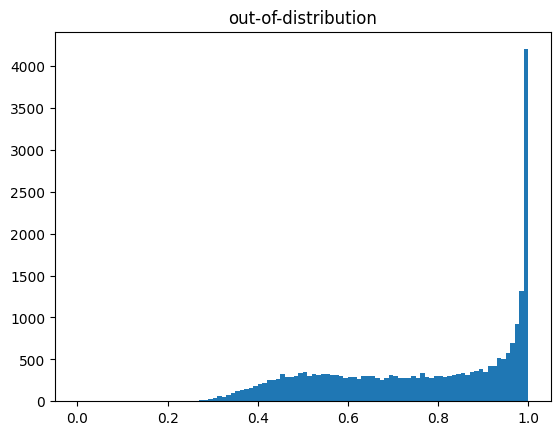

AUROC: 0.9191,	FPR95: 0.4843



In [13]:
# Test Baseline
base_ood_scores, ood_labels = test(net, in_test_loader, ood_test_loader)

# ODIN

In [14]:
def preproces_input(inputs, outputs, original_outputs, criterion, noise_magn):
    # Calculating the perturbation we need to add, that is,
    # the sign of gradient of cross entropy loss w.r.t. input
    labels = torch.argmax(original_outputs, dim=1)
    loss = criterion(outputs, labels)
    loss.backward()

    # Normalizing the gradient to binary in {0, 1}
    gradient =  torch.ge(inputs.grad.data, 0)
    gradient = (gradient.float() - 0.5) * 2
    # Normalizing the gradient to the same space of image
    for i in range(gradient[0].shape[0]):
        gradient[0][i] = (gradient[0][i] )/(pixel_std[i]/pixel_mean[i])

    # Adding small perturbations to images
    tempInputs = torch.add(inputs.data, noise_magn, gradient)

    return tempInputs

In [15]:
def inference_odin(net, testloader, criterion, temperature=10, noise_magn=0.0014):
    total_num = len(testloader.dataset)
    scores = torch.Tensor([]).to(device)
    correct_predicts = 0
    t0 = time.time()
    for j, (images, gt_labels) in enumerate(testloader):
        inputs = Variable(images.to(device), requires_grad=True)
        outputs = net(inputs)
        if noise_magn > 0:
          # Preprocess inputs
          tempInputs = preproces_input(inputs, outputs, outputs, criterion, noise_magn)
          outputs = net(Variable(tempInputs))

        # Using temperature scaling
        outputs = outputs / temperature
        probs, predicts = nn.Softmax(dim=1)(outputs).max(dim=1)

        scores = torch.cat([scores, probs.detach()])
        correct_predicts += (predicts == gt_labels.to(device)).sum()

        if j % 10 == 0:
          print("{:4}/{:4} batches processed, {:.1f} seconds used.".format(j+1, len(testloader), time.time() - t0))
          t0 = time.time()

    accuracy = correct_predicts / total_num
    print("Accuracy: {:.2f}%".format(accuracy * 100))

    return scores, accuracy

Processing in-distribution images


<ipython-input-14-7c918e731a24>:16: UserWarning: This overload of add is deprecated:
	add(Tensor input, Number alpha, Tensor other, *, Tensor out)
Consider using one of the following signatures instead:
	add(Tensor input, Tensor other, *, Number alpha, Tensor out) (Triggered internally at ../torch/csrc/utils/python_arg_parser.cpp:1485.)
  tempInputs = torch.add(inputs.data, noise_magn, gradient)


   1/  79 batches processed, 0.9 seconds used.
  11/  79 batches processed, 1.4 seconds used.
  21/  79 batches processed, 1.5 seconds used.
  31/  79 batches processed, 1.5 seconds used.
  41/  79 batches processed, 1.4 seconds used.
  51/  79 batches processed, 1.4 seconds used.
  61/  79 batches processed, 1.4 seconds used.
  71/  79 batches processed, 1.4 seconds used.
Accuracy: 94.55%


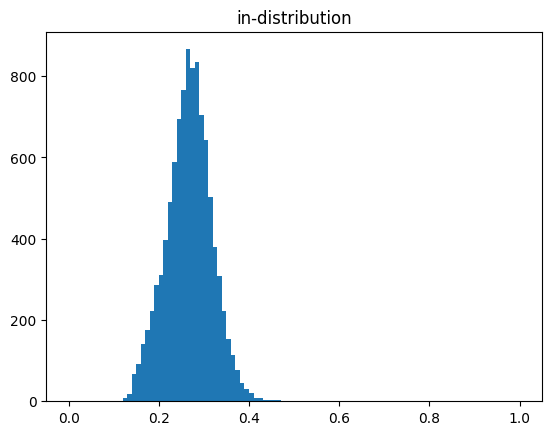

Processing out-of-distribution images
   1/ 204 batches processed, 0.1 seconds used.
  11/ 204 batches processed, 1.4 seconds used.
  21/ 204 batches processed, 1.4 seconds used.
  31/ 204 batches processed, 1.5 seconds used.
  41/ 204 batches processed, 1.5 seconds used.
  51/ 204 batches processed, 1.5 seconds used.
  61/ 204 batches processed, 1.4 seconds used.
  71/ 204 batches processed, 1.4 seconds used.
  81/ 204 batches processed, 1.4 seconds used.
  91/ 204 batches processed, 1.4 seconds used.
 101/ 204 batches processed, 1.4 seconds used.
 111/ 204 batches processed, 1.4 seconds used.
 121/ 204 batches processed, 1.5 seconds used.
 131/ 204 batches processed, 1.6 seconds used.
 141/ 204 batches processed, 1.5 seconds used.
 151/ 204 batches processed, 1.4 seconds used.
 161/ 204 batches processed, 1.4 seconds used.
 171/ 204 batches processed, 1.4 seconds used.
 181/ 204 batches processed, 1.4 seconds used.
 191/ 204 batches processed, 1.4 seconds used.
 201/ 204 batches proc

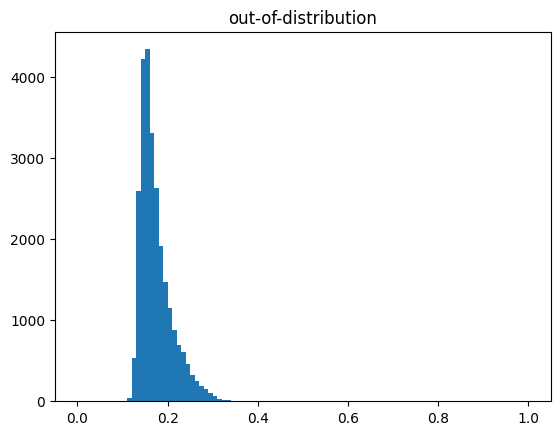

AUROC: 0.9290,	FPR95: 0.3209



In [16]:
# Test ODIN
odin_ood_scores, _ = test(net, in_test_loader, ood_test_loader, method="odin", temperature=10)

# Energy-based OOD detection

### Post-hoc method

In [17]:
def inference_ebo(net, testloader, temperature=10):
    net.eval()
    total_num = len(testloader.dataset)
    scores = torch.Tensor([]).to(device)
    correct_predicts = 0
    t0 = time.time()
    for j, (images, gt_labels) in enumerate(testloader):
      outputs = net(images.to(device))
      _, predicts = nn.Softmax(dim=1)(outputs).max(dim=1)
      cur_scores = - temperature * torch.logsumexp(outputs / temperature, dim=1)
      scores = torch.cat([scores, cur_scores.detach()])
      correct_predicts += (predicts == gt_labels.to(device)).sum()

      if j % 10 == 0:
        print("{:4}/{:4} batches processed, {:.1f} seconds used.".format(j+1, len(testloader), time.time() - t0))
        t0 = time.time()

    accuracy = correct_predicts / total_num
    print("Accuracy: {:.2f}%".format(accuracy * 100))

    return -scores, accuracy

Processing in-distribution images
   1/  79 batches processed, 0.1 seconds used.
  11/  79 batches processed, 0.6 seconds used.
  21/  79 batches processed, 0.7 seconds used.
  31/  79 batches processed, 0.7 seconds used.
  41/  79 batches processed, 0.7 seconds used.
  51/  79 batches processed, 0.7 seconds used.
  61/  79 batches processed, 0.7 seconds used.
  71/  79 batches processed, 0.6 seconds used.
Accuracy: 94.84%


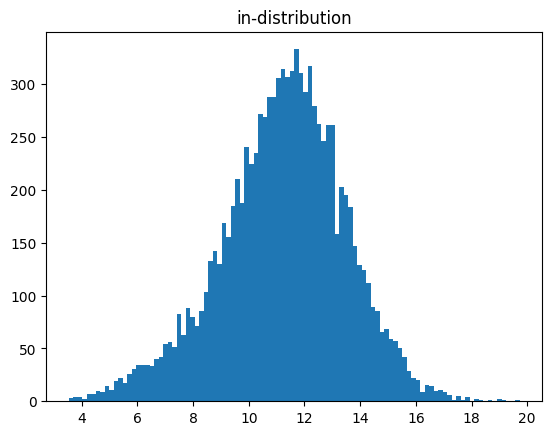

Processing out-of-distribution images
   1/ 204 batches processed, 0.1 seconds used.
  11/ 204 batches processed, 0.5 seconds used.
  21/ 204 batches processed, 0.5 seconds used.
  31/ 204 batches processed, 0.5 seconds used.
  41/ 204 batches processed, 0.5 seconds used.
  51/ 204 batches processed, 0.5 seconds used.
  61/ 204 batches processed, 0.5 seconds used.
  71/ 204 batches processed, 0.5 seconds used.
  81/ 204 batches processed, 0.5 seconds used.
  91/ 204 batches processed, 0.5 seconds used.
 101/ 204 batches processed, 0.5 seconds used.
 111/ 204 batches processed, 0.5 seconds used.
 121/ 204 batches processed, 0.5 seconds used.
 131/ 204 batches processed, 0.5 seconds used.
 141/ 204 batches processed, 0.5 seconds used.
 151/ 204 batches processed, 0.5 seconds used.
 161/ 204 batches processed, 0.5 seconds used.
 171/ 204 batches processed, 0.6 seconds used.
 181/ 204 batches processed, 0.7 seconds used.
 191/ 204 batches processed, 0.7 seconds used.
 201/ 204 batches proc

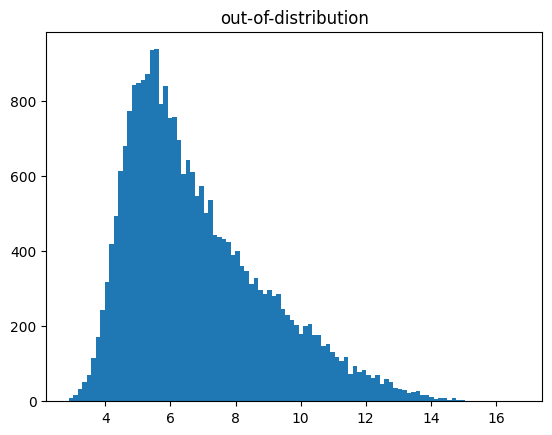

AUROC: 0.9108,	FPR95: 0.3536



In [18]:
# Test Energy-base OOD detection
ebo_ood_scores, _ = test(net, in_test_loader, ood_test_loader, method="ebo", temperature=1.0)

### Fine-tuning

In [19]:
def make_optimizer(net, lr=0.001, momuntum=0.9, decay=0.0005, nesterov=True):
  return torch.optim.SGD(net.parameters(), lr, momuntum, weight_decay=decay, nesterov=nesterov)

In [20]:
def cosine_annealing(step, total_steps, lr_max, lr_min):
    return lr_min + (lr_max - lr_min) * 0.5 * (
            1 + np.cos(step / total_steps * np.pi))

In [21]:
def make_scheduler(optimizer, epochs, iter_per_epoch, lr):
  scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer,
      lr_lambda=lambda step: cosine_annealing(step, epochs * iter_per_epoch, 1, 1e-6 / lr))
  return scheduler

In [22]:
def train(net, in_loader, ood_loader, epochs, optimizer, scheduler, temperature=10, m_in=-25, m_out=-7):
    net.train()
    max_iter = max(len(in_loader), len(ood_loader))
    loss_avg = 0
    t0 = time.time()
    for e in range(epochs):
      print("{}-th epoch starts...".format(e))
      for j, (in_set, out_set) in enumerate(zip(in_loader, ood_loader)):
        if j >= max_iter:
          break
        images = torch.cat((in_set[0], out_set[0]), 0)
        targets = in_set[1].to(device)

        outputs = net(images.to(device))

        scheduler.step()
        optimizer.zero_grad()

        loss = F.cross_entropy(outputs[:len(in_set[0])], targets)

        energy_out = -torch.logsumexp(outputs[len(in_set[0]):], dim=1)
        energy_in = -torch.logsumexp(outputs[:len(in_set[0])], dim=1)
        loss += 0.1*(torch.pow(F.relu(energy_in - m_in), 2).mean() + torch.pow(F.relu(m_out - energy_out), 2).mean())

        loss.backward()
        optimizer.step()

        loss_avg = loss_avg * 0.8 + float(loss) * 0.2

        if j % 10 == 0:
          print("{:4}/{:4} batches processed, {:.1f} seconds used. Loss: {:.4f}".format(j+1, max_iter, time.time() - t0, loss_avg))
          t0 = time.time()


In [23]:
epochs = 1
lr = 0.001
in_train_loader, in_num_classes = load_dataset('cifar10', bs_size=128, is_train=True, download=True)
ood_train_loader, ood_num_classes = load_dataset('svhn', bs_size=128, is_train=True, download=True)
optimizer = make_optimizer(net)
scheduler = make_scheduler(optimizer, epochs, len(in_train_loader), lr)

Files already downloaded and verified
Using downloaded and verified file: ./data/svhn/train_32x32.mat


In [24]:
# Finetuning...
train(net, in_train_loader, ood_train_loader, epochs, optimizer, scheduler, temperature=10, m_in=-25, m_out=-7)

0-th epoch starts...


/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:139: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "


   1/ 573 batches processed, 0.7 seconds used. Loss: 4.7549
  11/ 573 batches processed, 3.2 seconds used. Loss: 11.1775
  21/ 573 batches processed, 2.9 seconds used. Loss: 7.5332
  31/ 573 batches processed, 2.8 seconds used. Loss: 4.9358
  41/ 573 batches processed, 3.0 seconds used. Loss: 3.2208
  51/ 573 batches processed, 3.3 seconds used. Loss: 1.8734
  61/ 573 batches processed, 3.3 seconds used. Loss: 1.6213
  71/ 573 batches processed, 2.9 seconds used. Loss: 1.1821
  81/ 573 batches processed, 2.9 seconds used. Loss: 1.0240
  91/ 573 batches processed, 2.9 seconds used. Loss: 0.8518
 101/ 573 batches processed, 3.1 seconds used. Loss: 0.6056
 111/ 573 batches processed, 3.1 seconds used. Loss: 0.7459
 121/ 573 batches processed, 2.8 seconds used. Loss: 0.7733
 131/ 573 batches processed, 2.9 seconds used. Loss: 0.6224
 141/ 573 batches processed, 2.8 seconds used. Loss: 0.6063
 151/ 573 batches processed, 3.3 seconds used. Loss: 0.6538
 161/ 573 batches processed, 2.9 second

Processing in-distribution images
   1/  79 batches processed, 0.1 seconds used.
  11/  79 batches processed, 0.5 seconds used.
  21/  79 batches processed, 0.5 seconds used.
  31/  79 batches processed, 0.5 seconds used.
  41/  79 batches processed, 0.5 seconds used.
  51/  79 batches processed, 0.5 seconds used.
  61/  79 batches processed, 0.5 seconds used.
  71/  79 batches processed, 0.5 seconds used.
Accuracy: 94.30%


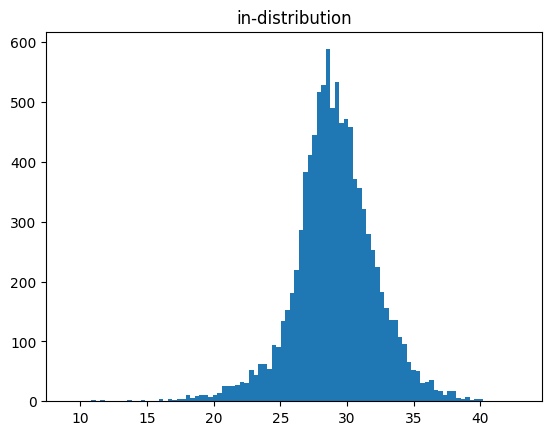

Processing out-of-distribution images
   1/ 204 batches processed, 0.1 seconds used.
  11/ 204 batches processed, 0.5 seconds used.
  21/ 204 batches processed, 0.5 seconds used.
  31/ 204 batches processed, 0.5 seconds used.
  41/ 204 batches processed, 0.5 seconds used.
  51/ 204 batches processed, 0.5 seconds used.
  61/ 204 batches processed, 0.5 seconds used.
  71/ 204 batches processed, 0.5 seconds used.
  81/ 204 batches processed, 0.7 seconds used.
  91/ 204 batches processed, 0.7 seconds used.
 101/ 204 batches processed, 0.7 seconds used.
 111/ 204 batches processed, 0.7 seconds used.
 121/ 204 batches processed, 0.7 seconds used.
 131/ 204 batches processed, 0.6 seconds used.
 141/ 204 batches processed, 0.5 seconds used.
 151/ 204 batches processed, 0.5 seconds used.
 161/ 204 batches processed, 0.5 seconds used.
 171/ 204 batches processed, 0.5 seconds used.
 181/ 204 batches processed, 0.5 seconds used.
 191/ 204 batches processed, 0.5 seconds used.
 201/ 204 batches proc

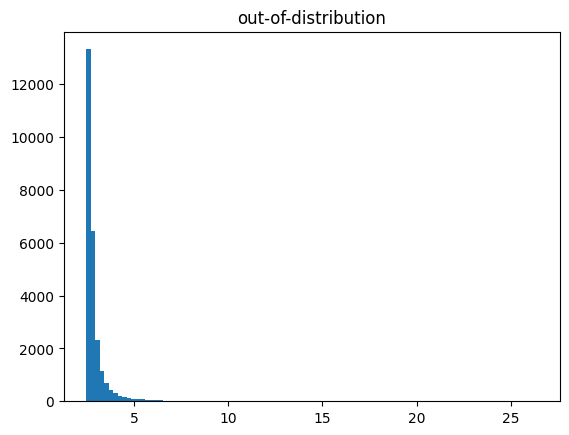

AUROC: 0.9999,	FPR95: 0.0003



In [25]:
# Test Energy-base OOD detection with fine-tuned model
finetuned_ebo_ood_scores, _ = test(net, in_test_loader, ood_test_loader, method="ebo", temperature=1.0)

In [26]:
def draw_roc_curve(ood_scores, ood_labels):
  plt.figure(figsize=(8, 6))
  color = ['blue', 'green', 'red', 'orange']

  for i, method in enumerate(ood_scores):
    # Calculate ROC curve
    fpr, tpr, thresholds = roc_curve(ood_labels, ood_scores[method])

    # Calculate AUC score
    auc_score = roc_auc_score(ood_labels, ood_scores[method])

    # Plot ROC curve
    plt.plot(fpr, tpr, color=color[i], lw=2, label=f'AUC = {auc_score:.5f}')
    plt.plot([0, 1], [0, 1], color='gray', linestyle='--')

  plt.xlim([0.0, 1.0])
  plt.ylim([0.0, 1.05])
  plt.xlabel('False Positive Rate')
  plt.ylabel('True Positive Rate')
  plt.title('Receiver Operating Characteristic (ROC) Curve')
  plt.legend(loc='lower right')
  plt.show()

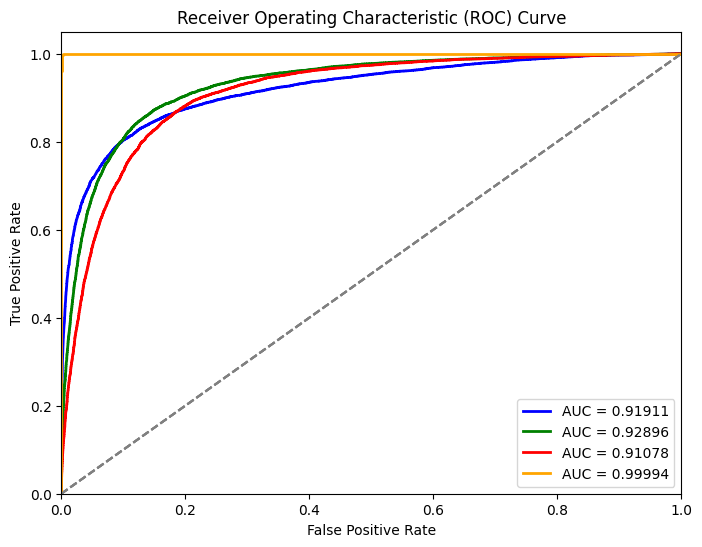

In [27]:
ood_scores = {"baseline": base_ood_scores, "odin": odin_ood_scores, "ebo": ebo_ood_scores, "ebo-finetuned": finetuned_ebo_ood_scores}
draw_roc_curve(ood_scores, ood_labels)